## langgraph parralel process

In [24]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict
import google.generativeai as genai


from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("gen_api")
def call_gemini_model(prompt: str) -> str:
    model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
    response = model.invoke(prompt).content
    return response

In [25]:
class cricket_stats(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int
    boundries_per: float
    strike_rate: float
    bpb: float
    summary: str


In [26]:
def boundries_per(state: cricket_stats) -> float:
    boundries_per = (state['fours'] + state['sixes']) / state['balls'] * 100
    return {"boundries_per": boundries_per}

def strike_rate(state: cricket_stats) -> float:
    strike_rate = (state['runs'] / state['balls']) * 100  
    return {"strike_rate":strike_rate}

def bpb(state: cricket_stats) -> float:
    bpb = state['balls'] / (state['fours'] + state['sixes'])
    return {"bpb":bpb}

def summary(state: cricket_stats) -> str:
    prompt = f"Provide a brief summary of a cricket player's performance with the following stats: Runs: {state['runs']}, Balls: {state['balls']}, Fours: {state['fours']}, Sixes: {state['sixes']}, Boundaries Percentage: {state['boundries_per']:.2f}%, Strike Rate: {state['strike_rate']:.2f}, Balls per Boundary: {state['bpb']:.2f}."
    response = call_gemini_model(prompt)
    return {"summary":response}

In [27]:
# define the state graph
graph=StateGraph(cricket_stats)

# define graph nodes
graph.add_node("boundries_per",boundries_per)
graph.add_node("strike_rate",strike_rate)
graph.add_node("bpb",bpb)
graph.add_node("summary",summary)

# define edges
graph.add_edge(START,"boundries_per")
graph.add_edge(START,"bpb")
graph.add_edge(START,"strike_rate")
graph.add_edge(("boundries_per","bpb","strike_rate"),"summary")
graph.add_edge("summary",END)

# compile the graph
workflow= graph.compile()

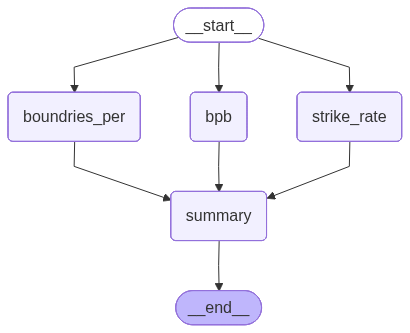

In [31]:
workflow

In [30]:
# execute the graph
initial_state: cricket_stats = {
    "runs": 120,
    "balls": 80,
    "fours": 10,
    "sixes": 5
}   
final_state = workflow.invoke(initial_state)
print(final_state)


{'runs': 120, 'balls': 80, 'fours': 10, 'sixes': 5, 'boundries_per': 18.75, 'strike_rate': 150.0, 'bpb': 5.333333333333333, 'summary': 'This cricket player delivered a **dominant and aggressive innings**. They scored a significant **120 runs off just 80 balls**, demonstrating excellent shot-making with **10 fours and 5 sixes**. Their high **strike rate of 150.00** indicates they scored runs quickly and put pressure on the opposition bowlers. The **boundaries percentage of 18.75%** and **balls per boundary of 5.33** further highlight their ability to find the ropes frequently and maintain an attacking tempo throughout their stay at the crease.'}
